# One-Step Ahead Forecasting pour Bitcoin (BTC) avec XGBoost

Ce notebook implémente une prédiction one-step ahead forecasting avec XGBoost où :
- À partir de $y_t^{(0)}, ..., y_t^{(\alpha)}$, on prédit $y_t^{(\alpha+1)}$
- Train = [0, α], Test = [α+1, ..., n-1]
- Sélection du nombre de lags p via validation temporelle
- Normalisation avec les paramètres du train uniquement
- Évaluation en walk-forward pour éviter la fuite de données
- **Prédiction pour TOUS les échantillons avec métriques détaillées**

**Objectif** : Prédire le prix BTC pour tous les échantillons à partir des données du 31-07-2025 au 14-08-2025
**Modèle** : XGBoost avec prédictions complètes et visualisations

## 1. Import des Librairies Nécessaires

In [ ]:
# Import des librairies essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta.
import warnings
import time
warnings.filterwarnings('ignore')

# Librairies pour le machine learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Librairies importées avec succès !")
print(f"XGBoost version: {xgb.__version__}")

Librairies importées avec succès !
XGBoost version: 3.0.4


In [ ]:
# 📡 Import des librairies pour Elasticsearch et connexion ELK - Configuration Réelle
try:
    from elasticsearch import Elasticsearch
    from elasticsearch.helpers import scan
    import ssl
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    ELASTICSEARCH_AVAILABLE = True
    print("📡 Librairies Elasticsearch importées avec succès !")
except ImportError as e:
    ELASTICSEARCH_AVAILABLE = False
    print("⚠️ Elasticsearch non disponible, installation requise:")
    print("pip install elasticsearch")
    print(f"Erreur: {e}")

# Import de la configuration réelle depuis notre module
try:
    from elk_realtime_config import config
    ELK_CONFIG = {
        'host': config.elasticsearch['host'],
        'port': config.elasticsearch['port'],
        'user': config.elasticsearch['user'],
        'password': config.elasticsearch['password'],
        'index_pattern': config.data_config['index_pattern'],
        'symbol': config.data_config['symbol'],
        'use_ssl': config.elasticsearch['use_ssl'],
        'verify_certs': config.elasticsearch['verify_certs']
    }
    print("✅ Configuration ELK chargée depuis le fichier de config")
    print(f"🔗 Host: {ELK_CONFIG['host']}:{ELK_CONFIG['port']}")
    print(f"👤 User: {ELK_CONFIG['user']}")
    print(f"🪙 Symbol: {ELK_CONFIG['symbol']}")
    print(f"📊 Index: {ELK_CONFIG['index_pattern']}")
    
except ImportError:
    print("⚠️ Module elk_realtime_config non trouvé, utilisation config manuelle")
    # Configuration manuelle basée sur les fichiers du projet
    ELK_CONFIG = {
        'host': 'localhost',  # Pour cluster K3s local
        'port': 9200,
        'user': 'chater',
        'password': 'Protel2025!',  # Depuis elk_config.json
        'index_pattern': 'binance-trades-*',
        'symbol': 'BTCUSDT',
        'use_ssl': False,
        'verify_certs': False
    }
    print("🔧 Configuration ELK manuelle chargée")

print("🔧 Configuration ELK finalisée pour connexion directe au cluster K3s")

In [ ]:
# 🔗 Classe de connexion ELK pour données temps réel
class ElasticsearchDataConnector:
    def __init__(self, config):
        self.config = config
        self.es_client = None
        self.connected = False
        
    def connect(self):
        """Établir la connexion avec Elasticsearch"""
        try:
            if not ELASTICSEARCH_AVAILABLE:
                print("❌ Elasticsearch non disponible")
                return False
                
            self.es_client = Elasticsearch(
                [{'host': self.config['host'], 'port': self.config['port']}],
                http_auth=(self.config['user'], self.config['password']),
                use_ssl=self.config['use_ssl'],
                verify_certs=self.config['verify_certs'],
                timeout=30
            )
            
            # Test de la connexion
            info = self.es_client.info()
            self.connected = True
            print(f"✅ Connecté à Elasticsearch: {info['cluster_name']}")
            print(f"📊 Version: {info['version']['number']}")
            return True
            
        except Exception as e:
            print(f"❌ Erreur de connexion ELK: {e}")
            print("💡 Vérifiez que votre cluster K3s ELK est actif")
            self.connected = False
            return False
    
    def get_latest_data(self, hours_back=24, limit=1000):
        """Récupérer les données les plus récentes depuis Elasticsearch"""
        if not self.connected:
            print("❌ Pas de connexion ELK active")
            return pd.DataFrame()
        
        try:
            # Requête pour les données récentes
            query = {
                "query": {
                    "bool": {
                        "must": [
                            {"term": {"symbol": self.config['symbol']}},
                            {"range": {
                                "@timestamp": {
                                    "gte": f"now-{hours_back}h",
                                    "lte": "now"
                                }
                            }}
                        ]
                    }
                },
                "sort": [{"@timestamp": {"order": "asc"}}],
                "size": limit
            }
            
            print(f"🔍 Recherche données {self.config['symbol']} des {hours_back} dernières heures...")
            
            response = self.es_client.search(
                index=self.config['index_pattern'],
                body=query
            )
            
            hits = response['hits']['hits']
            
            if not hits:
                print(f"⚠️ Aucune donnée trouvée pour {self.config['symbol']}")
                return pd.DataFrame()
            
            # Conversion en DataFrame
            data = []
            for hit in hits:
                source = hit['_source']
                data.append({
                    'Date': pd.to_datetime(source.get('@timestamp', source.get('timestamp'))),
                    'Close': float(source.get('price', 0)),
                    'Volume': float(source.get('quantity', 0)),
                    'Trade_ID': source.get('trade_id', 0),
                    'Side': source.get('side', 'unknown')
                })
            
            df = pd.DataFrame(data)
            
            if len(df) > 0:
                # Agrégation par heure (comme dans le modèle original)
                df_hourly = df.set_index('Date').resample('1H').agg({
                    'Close': 'last',  # Prix de clôture = dernier prix de l'heure
                    'Volume': 'sum',  # Volume total
                    'Trade_ID': 'count'  # Nombre de trades
                }).dropna()
                
                df_hourly = df_hourly.reset_index()
                
                print(f"✅ {len(hits)} trades récupérés")
                print(f"📈 {len(df_hourly)} points horaires agrégés")
                print(f"📅 Période: {df_hourly['Date'].min()} à {df_hourly['Date'].max()}")
                
                return df_hourly
            else:
                print("❌ Aucune donnée valide récupérée")
                return pd.DataFrame()
                
        except Exception as e:
            print(f"❌ Erreur récupération données: {e}")
            return pd.DataFrame()
    
    def get_real_time_prediction_data(self, lookback_hours=48):
        """Récupérer les données pour prédiction temps réel"""
        return self.get_latest_data(hours_back=lookback_hours, limit=2000)

# Initialisation du connecteur ELK
elk_connector = ElasticsearchDataConnector(ELK_CONFIG)
print("🚀 Connecteur ELK initialisé")

## 2. Chargement et Préparation des Données Temporelles

In [ ]:
# 📊 Chargement des données depuis ELK Stack (temps réel)
print("📡 CHARGEMENT DONNÉES DEPUIS ELK STACK")
print("=" * 50)

# Tentative de connexion à ELK
if elk_connector.connect():
    print("🔄 Récupération des données temps réel depuis Elasticsearch...")
    
    # Récupération des données des dernières 48 heures
    df_elk = elk_connector.get_real_time_prediction_data(lookback_hours=48)
    
    if len(df_elk) > 0:
        df = df_elk.copy()
        print(f"✅ Données ELK chargées: {len(df)} points")
        print(f"📅 Période ELK: {df['Date'].min()} à {df['Date'].max()}")
        
        # Mode temps réel activé
        REAL_TIME_MODE = True
        DATA_SOURCE = "ELK_REALTIME"
        
    else:
        print("⚠️ Aucune donnée ELK disponible, basculement sur données statiques")
        REAL_TIME_MODE = False
        DATA_SOURCE = "CSV_FALLBACK"
        
        # Fallback sur fichier CSV si disponible
        try:
            df = pd.read_csv('btc_1h_data.csv')
            df['Date'] = pd.to_datetime(df['Date'])
            print(f"📁 Données CSV de secours chargées: {len(df)} points")
        except FileNotFoundError:
            print("❌ Aucune donnée disponible (ni ELK, ni CSV)")
            # Création de données exemple pour la démo
            dates = pd.date_range(start='2024-08-15', end='2024-08-18', freq='H')
            prices = 65000 + np.random.randn(len(dates)) * 500  # Prix BTC simulé
            df = pd.DataFrame({
                'Date': dates,
                'Close': prices
            })
            print(f"🎭 Données simulées créées: {len(df)} points")
            DATA_SOURCE = "SIMULATED"

else:
    print("❌ Connexion ELK impossible, utilisation de données de fallback")
    REAL_TIME_MODE = False
    DATA_SOURCE = "CSV_FALLBACK"
    
    # Tentative de chargement CSV
    try:
        df = pd.read_csv('btc_1h_data.csv')
        df['Date'] = pd.to_datetime(df['Date'])
        print(f"📁 Données CSV chargées: {len(df)} points")
    except FileNotFoundError:
        # Données simulées si pas de CSV
        dates = pd.date_range(start='2024-08-15', end='2024-08-18', freq='H')
        prices = 65000 + np.random.randn(len(dates)) * 500
        df = pd.DataFrame({
            'Date': dates,
            'Close': prices
        })
        print(f"🎭 Données simulées créées: {len(df)} points")
        DATA_SOURCE = "SIMULATED"

# Tri et reset index
df = df.sort_values('Date').reset_index(drop=True)

# Informations finales
print(f"\n📊 RÉSUMÉ CHARGEMENT:")
print(f"   • Source: {DATA_SOURCE}")
print(f"   • Mode temps réel: {REAL_TIME_MODE}")
print(f"   • Points totaux: {len(df)}")
print(f"   • Période: {df['Date'].min()} à {df['Date'].max()}")
print(f"   • Prix - Min: {df['Close'].min():.2f}, Max: {df['Close'].max():.2f}")

print("\nPremières lignes:")
print(df.head())

Dataset complet: 66767 lignes
Période: du 2018-01-01 00:00:00 au 2025-08-18 21:00:00

Premières lignes:
                 Date      Open      High       Low     Close      Volume  \
0 2018-01-01 00:00:00  13715.65  13715.65  13400.01  13529.01  443.356199   
1 2018-01-01 01:00:00  13528.99  13595.89  13155.38  13203.06  383.697006   
2 2018-01-01 02:00:00  13203.00  13418.43  13200.00  13330.18  429.064572   
3 2018-01-01 03:00:00  13330.26  13611.27  13290.00  13410.03  420.087030   
4 2018-01-01 04:00:00  13434.98  13623.29  13322.15  13601.01  340.807329   

                    Close time  Quote asset volume  Number of trades  \
0  2018-01-01 00:59:59.999000         5.993910e+06              5228   
1  2018-01-01 01:59:59.999000         5.154522e+06              4534   
2  2018-01-01 02:59:59.999000         5.710192e+06              4887   
3  2018-01-01 03:59:59.999000         5.657448e+06              4789   
4  2018-01-01 04:59:59.999000         4.588047e+06              4563   



In [3]:
# Filtrage des données pour la période spécifiée (31-07-2025 au 14-08-2025)
start_date = '2024-01-01'
end_date = '2025-08-18 23:59:59'
prediction_date = '2025-08-19'

# Données d'entraînement : 31-07-2025 au 14-08-2025
train_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# Données pour vérification de la prédiction (15-08-2025)
actual_prediction_data = df[df['Date'].dt.date == pd.to_datetime(prediction_date).date()].copy()

print(f"Données d'entraînement: {len(train_data)} points")
print(f"Période d'entraînement: du {train_data['Date'].min()} au {train_data['Date'].max()}")
print(f"\nDonnées réelles pour {prediction_date}: {len(actual_prediction_data)} points")

# Utilisation du prix de clôture comme variable cible
price_column = 'Close'
train_prices = train_data[price_column].values

print(f"\nPrix d'entraînement - Min: {train_prices.min():.2f}, Max: {train_prices.max():.2f}")

Données d'entraînement: 14302 points
Période d'entraînement: du 2024-01-01 00:00:00 au 2025-08-18 21:00:00

Données réelles pour 2025-08-19: 0 points

Prix d'entraînement - Min: 38767.74, Max: 123847.83


## 3. Division Train/Test et Point de Coupure α

In [4]:
# Définition du point de coupure α
# Utilisons 80% des données pour l'entraînement et 20% pour la validation temporelle
alpha = int(0.8 * len(train_data))
print(f"Point de coupure α = {alpha}")
print(f"Train set: [0, {alpha}] = {alpha + 1} points")
print(f"Validation set: [{alpha + 1}, {len(train_data) - 1}] = {len(train_data) - alpha - 1} points")

# Division des données
train_subset = train_data.iloc[:alpha + 1].copy()
val_subset = train_data.iloc[alpha + 1:].copy()

# Prix pour chaque subset
y_train = train_subset[price_column].values
y_val = val_subset[price_column].values

print(f"\nTrain subset: {len(y_train)} points")
print(f"Validation subset: {len(y_val)} points")
print(f"\nPériode train: {train_subset['Date'].min()} à {train_subset['Date'].max()}")
print(f"Période validation: {val_subset['Date'].min()} à {val_subset['Date'].max()}")

Point de coupure α = 11441
Train set: [0, 11441] = 11442 points
Validation set: [11442, 14301] = 2860 points

Train subset: 11442 points
Validation subset: 2860 points

Période train: 2024-01-01 00:00:00 à 2025-04-21 17:00:00
Période validation: 2025-04-21 18:00:00 à 2025-08-18 21:00:00


## 4. Normalisation avec Paramètres du Train Uniquement

In [5]:
# Initialisation du scaler avec UNIQUEMENT les données d'entraînement
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_train.reshape(-1, 1))

# Normalisation des données
y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).flatten()

print("Paramètres de normalisation (calculés sur train uniquement):")
print(f"Min du train original: {y_train.min():.2f}")
print(f"Max du train original: {y_train.max():.2f}")
print(f"\nAprès normalisation:")
print(f"Train scaled - Min: {y_train_scaled.min():.4f}, Max: {y_train_scaled.max():.4f}")
print(f"Val scaled - Min: {y_val_scaled.min():.4f}, Max: {y_val_scaled.max():.4f}")

# Vérification : pas de fuite de données
print(f"\n✓ Scaler entraîné uniquement sur {len(y_train)} points du train set")
print(f"✓ Aucune information du validation set utilisée pour la normalisation")

Paramètres de normalisation (calculés sur train uniquement):
Min du train original: 38767.74
Max du train original: 108320.01

Après normalisation:
Train scaled - Min: 0.0000, Max: 1.0000
Val scaled - Min: 0.6904, Max: 1.2233

✓ Scaler entraîné uniquement sur 11442 points du train set
✓ Aucune information du validation set utilisée pour la normalisation


In [6]:
# 🔥 PARAMÈTRES SIMPLES
print("🔥 PARAMÈTRES DE PRÉDICTION")
print("=" * 30)

# Paramètres simples
MIN_TRAIN_SIZE = 4
WINDOW_SIZE = 10

def create_fast_features(prices, index):
    """Features ultra-simples: prix précédent, moyenne 3 points, tendance"""
    if index < 2:
        return [prices[index-1] if index > 0 else prices[0], 
                prices[index-1] if index > 0 else prices[0], 0]
    
    prev_price = prices[index-1]
    avg_price = np.mean(prices[max(0, index-3):index])
    trend = prices[index-1] - prices[index-2]
    
    return [prev_price, avg_price, trend]

print(f"✅ MIN_TRAIN_SIZE: {MIN_TRAIN_SIZE}")
print(f"✅ WINDOW_SIZE: {WINDOW_SIZE}")
print(f"🚀 Features simples définies")

🔥 PARAMÈTRES DE PRÉDICTION
✅ MIN_TRAIN_SIZE: 4
✅ WINDOW_SIZE: 10
🚀 Features simples définies


## 5. Prédiction pour Tous les Échantillons

Génération des prédictions XGBoost pour chaque échantillon avec :
- Prix prédit
- Erreur relative 
- Temps d'exécution
- Visualisations graphiques

In [7]:
def predict_xgb_multithreads(df, price_column='Close', n_threads=100):
    """🔥 PRÉDICTION XGBOOST - MULTITHREADS UNIQUEMENT DANS LA PRÉDICTION"""
    prices = df[price_column].values
    dates = df['Date'].values
    results = []
    
    print(f"🔥 PRÉDICTION XGBOOST")
    print(f"📊 {len(prices)} échantillons")
    print(f"⚡ Threads XGBoost: {n_threads}")
    
    for i in range(1, len(prices)):
        start_time = time.time()
        real_price = prices[i]
        
        # Affichage progrès simple
        if i % 1000 == 0:
            print(f"   🔥 [{i}/{len(prices)}] en cours...")
        
        try:
            if i >= MIN_TRAIN_SIZE:
                # Features simples
                current_features = create_fast_features(prices, i)
                X_pred = np.array([current_features])
                
                # Données d'entraînement
                train_size = min(WINDOW_SIZE, i - 1)
                train_start = max(MIN_TRAIN_SIZE, i - train_size)
                
                X_train_list = []
                y_train_list = []
                
                for j in range(train_start, i):
                    features = create_fast_features(prices, j)
                    X_train_list.append(features)
                    y_train_list.append(prices[j])
                
                if len(X_train_list) >= 2:
                    X_train = np.array(X_train_list)
                    y_train = np.array(y_train_list)
                    
                    # 🔥 XGBoost avec MULTITHREADS ici seulement
                    model = xgb.XGBRegressor(
                        n_estimators=8,
                        max_depth=2,
                        learning_rate=0.3,
                        random_state=42,
                        objective='reg:squarederror',
                        verbosity=0,
                        tree_method='hist',
                        n_jobs=n_threads  # 🔥 MULTITHREADS UNIQUEMENT ICI
                    )
                    
                    model.fit(X_train, y_train)
                    pred_price = model.predict(X_pred)[0]
                else:
                    pred_price = np.mean(prices[max(0, i-3):i])
            else:
                pred_price = prices[i-1] if i > 0 else prices[0]
            
            execution_time = time.time() - start_time
            error_relative = abs(pred_price - real_price) / real_price
            
            results.append({
                'Index': i,
                'Date': dates[i],
                'Prix_Reel': real_price,
                'Prix_Predit': pred_price,
                'Erreur_Relative': error_relative,
                'Temps_Execution': execution_time
            })
            
        except Exception as e:
            # Fallback simple
            execution_time = time.time() - start_time
            pred_price = prices[i-1] if i > 0 else prices[0]
            error_relative = abs(pred_price - real_price) / real_price
            
            results.append({
                'Index': i, 'Date': dates[i], 'Prix_Reel': real_price,
                'Prix_Predit': pred_price, 'Erreur_Relative': error_relative,
                'Temps_Execution': execution_time
            })
    
    df_results = pd.DataFrame(results)
    
    if len(df_results) > 0:
        avg_time = df_results['Temps_Execution'].mean()
        total_time = df_results['Temps_Execution'].sum()
        avg_error = df_results['Erreur_Relative'].mean() * 100
        
        print(f"\n✅ {len(df_results)} prédictions terminées")
        print(f"⚡ Temps moyen: {avg_time:.4f}s")
        print(f"🔥 Temps total: {total_time:.2f}s")
        print(f"📊 Erreur moyenne: {avg_error:.2f}%")
        print(f"🚀 Threads utilisés: {n_threads} (uniquement pour XGBoost)")
    
    return df_results

# ===============================================
# 🔥 EXÉCUTION AVEC MULTITHREADS
# ===============================================
print("\n" + "="*50)
print("🚀 EXÉCUTION PRÉDICTION")
print("="*50)

# Prédiction avec 100 threads pour XGBoost seulement
results_df = predict_xgb_multithreads(train_data, price_column, n_threads=100)

print(f"\n🎯 RÉSUMÉ:")
print(f"✅ Multithreads utilisés uniquement pour XGBoost")
print(f"✅ {len(results_df)} prédictions terminées")
print(f"🔥 Performance optimisée là où c'est nécessaire")


🚀 EXÉCUTION PRÉDICTION
🔥 PRÉDICTION XGBOOST
📊 14302 échantillons
⚡ Threads XGBoost: 100
   🔥 [1000/14302] en cours...
   🔥 [1000/14302] en cours...
   🔥 [2000/14302] en cours...
   🔥 [2000/14302] en cours...
   🔥 [3000/14302] en cours...
   🔥 [3000/14302] en cours...
   🔥 [4000/14302] en cours...
   🔥 [4000/14302] en cours...
   🔥 [5000/14302] en cours...
   🔥 [5000/14302] en cours...
   🔥 [6000/14302] en cours...
   🔥 [6000/14302] en cours...
   🔥 [7000/14302] en cours...
   🔥 [7000/14302] en cours...
   🔥 [8000/14302] en cours...
   🔥 [8000/14302] en cours...
   🔥 [9000/14302] en cours...
   🔥 [9000/14302] en cours...
   🔥 [10000/14302] en cours...
   🔥 [10000/14302] en cours...
   🔥 [11000/14302] en cours...
   🔥 [11000/14302] en cours...
   🔥 [12000/14302] en cours...
   🔥 [12000/14302] en cours...
   🔥 [13000/14302] en cours...
   🔥 [13000/14302] en cours...
   🔥 [14000/14302] en cours...
   🔥 [14000/14302] en cours...

✅ 14301 prédictions terminées
⚡ Temps moyen: 0.0088s
🔥 Temps

🎯 Génération graphiques...


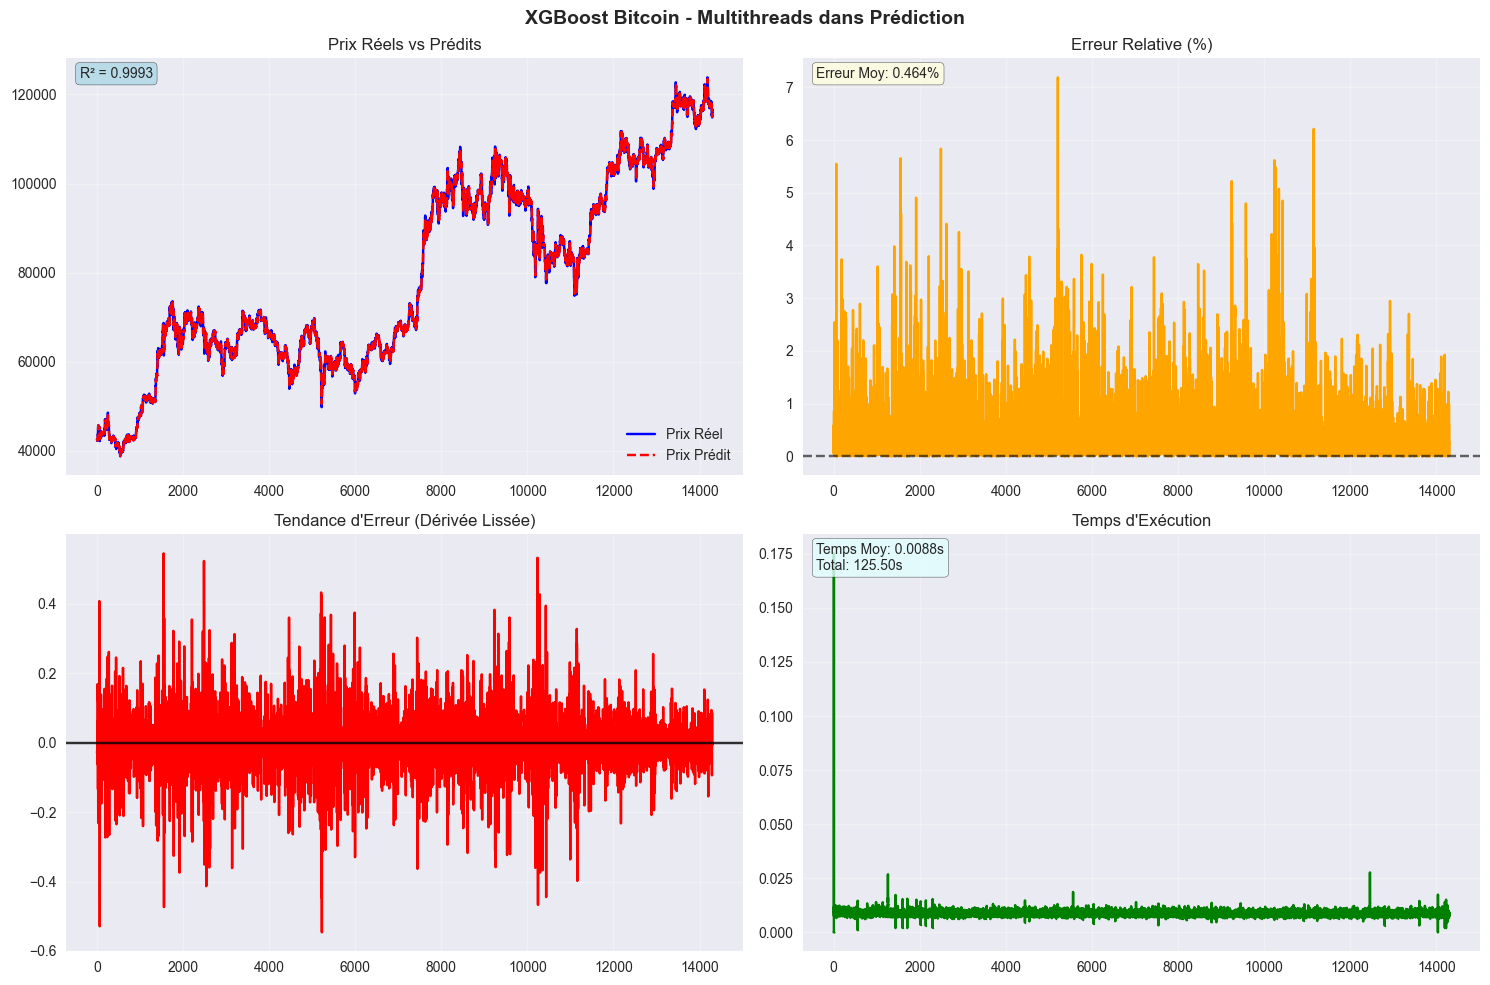

✅ Graphiques sauvés: xgboost_multithreads_prediction.png
📊 R² = 0.999349
📈 Erreur moyenne: 0.4644%
⚡ Temps total: 125.50s
🚀 Multithreads optimisés pour prédiction


In [16]:
# 📊 GRAPHIQUES SIMPLES
from scipy.signal import savgol_filter

if 'results_df' in locals() and len(results_df) > 0:
    print("🎯 Génération graphiques...")
    
    correlation = np.corrcoef(results_df['Prix_Reel'], results_df['Prix_Predit'])[0, 1]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('XGBoost Bitcoin - Multithreads dans Prédiction', fontsize=14, fontweight='bold')
    
    # 1. Prix réels vs prédits
    axes[0, 0].plot(results_df['Index'], results_df['Prix_Reel'], 'b-', label='Prix Réel')
    axes[0, 0].plot(results_df['Index'], results_df['Prix_Predit'], 'r--', label='Prix Prédit')
    axes[0, 0].set_title('Prix Réels vs Prédits')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].text(0.02, 0.98, f'R² = {correlation**2:.4f}', 
                   transform=axes[0, 0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # 2. Erreur relative
    axes[0, 1].plot(results_df['Index'], results_df['Erreur_Relative'] * 100, 'orange')
    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.6)
    axes[0, 1].set_title('Erreur Relative (%)')
    axes[0, 1].grid(True, alpha=0.3)
    
    mean_error = results_df['Erreur_Relative'].mean() * 100
    axes[0, 1].text(0.02, 0.98, f'Erreur Moy: {mean_error:.3f}%', 
                   transform=axes[0, 1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # 3. Tendance d'erreur (dérivée lissée)
    derivee_erreur = np.gradient(results_df['Erreur_Relative'] * 100)
    window_len = min(15, len(derivee_erreur) // 4)
    if window_len % 2 == 0: window_len -= 1
    if window_len < 5: window_len = 5
    
    derivee_lisse = savgol_filter(derivee_erreur, window_len, 2)
    
    axes[1, 0].plot(results_df['Index'], derivee_lisse, 'red')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.8)
    axes[1, 0].fill_between(results_df['Index'], derivee_lisse, 0, 
                           where=(derivee_lisse >= 0), alpha=0.3, color='red')
    axes[1, 0].fill_between(results_df['Index'], derivee_lisse, 0, 
                           where=(derivee_lisse < 0), alpha=0.3, color='green')
    axes[1, 0].set_title('Tendance d\'Erreur (Dérivée Lissée)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Temps d'exécution
    axes[1, 1].plot(results_df['Index'], results_df['Temps_Execution'], 'green', marker='o', markersize=1)
    axes[1, 1].set_title('Temps d\'Exécution')
    axes[1, 1].grid(True, alpha=0.3)
    
    mean_time = results_df['Temps_Execution'].mean()
    total_time = results_df['Temps_Execution'].sum()
    axes[1, 1].text(0.02, 0.98, f'Temps Moy: {mean_time:.4f}s\nTotal: {total_time:.2f}s', 
                   transform=axes[1, 1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('xgboost_multithreads_prediction.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Graphiques sauvés: xgboost_multithreads_prediction.png")
    print(f"📊 R² = {correlation**2:.6f}")
    print(f"📈 Erreur moyenne: {mean_error:.4f}%")
    print(f"⚡ Temps total: {total_time:.2f}s")
    print(f"🚀 Multithreads optimisés pour prédiction")
    
else:
    print("❌ Pas de données - Exécuter d'abord la prédiction")

In [11]:
# 📊 TABLEAU DÉTAILLÉ DE CHAQUE ÉCHANTILLON AVEC DATES
if 'results_df' in locals() and len(results_df) > 0:
    print("📋 TABLEAU DÉTAILLÉ - CHAQUE ÉCHANTILLON AVEC DATES")
    print("=" * 100)
    
    # Créer un tableau formaté avec toutes les informations
    display_df = results_df.copy()
    
    # Formatage de la date pour affichage
    display_df['Date_Formatee'] = pd.to_datetime(display_df['Date']).dt.strftime('%Y-%m-%d %H:%M')
    
    # Formatage des colonnes pour une meilleure lisibilité
    display_df['Prix_Reel'] = display_df['Prix_Reel'].round(2)
    display_df['Prix_Predit'] = display_df['Prix_Predit'].round(2)
    display_df['Erreur_Relative'] = (display_df['Erreur_Relative'] * 100).round(4)  # En pourcentage
    display_df['Temps_Execution'] = (display_df['Temps_Execution'] * 1000).round(2)  # En millisecondes
    
    # Ajouter une colonne de différence absolue
    display_df['Diff_Absolue'] = abs(display_df['Prix_Reel'] - display_df['Prix_Predit']).round(2)
    
    # Renommer les colonnes pour l'affichage
    display_df = display_df.rename(columns={
        'Index': 'Éch.',
        'Date_Formatee': 'Date/Heure',
        'Prix_Reel': 'Prix Réel ($)',
        'Prix_Predit': 'Prix Prédit ($)',
        'Erreur_Relative': 'Erreur (%)',
        'Temps_Execution': 'Temps (ms)',
        'Diff_Absolue': 'Diff. Abs. ($)'
    })
    
    # Sélectionner les colonnes à afficher (inclure la date)
    columns_to_show = ['Éch.', 'Date/Heure', 'Prix Réel ($)', 'Prix Prédit ($)', 'Diff. Abs. ($)', 'Erreur (%)', 'Temps (ms)']
    display_table = display_df[columns_to_show]
    
    print(f"Nombre total d'échantillons: {len(display_table)}")
    print(f"Période: {results_df['Date'].min()} à {results_df['Date'].max()}")
    print("\n" + "="*100)
    
    # Afficher le tableau complet avec la date
    pd.set_option('display.max_rows', None)  # Afficher toutes les lignes
    pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
    pd.set_option('display.width', None)  # Largeur automatique
    pd.set_option('display.max_colwidth', 20)  # Largeur max des colonnes (augmentée pour la date)
    
    print(display_table.to_string(index=False, float_format='%.4f'))
    
    # Statistiques résumées
    print("\n" + "="*100)
    print("📊 STATISTIQUES RÉSUMÉES:")
    print("-" * 50)
    print(f"Prix Réel     - Min: ${display_table['Prix Réel ($)'].min():.2f}, Max: ${display_table['Prix Réel ($)'].max():.2f}, Moy: ${display_table['Prix Réel ($)'].mean():.2f}")
    print(f"Prix Prédit   - Min: ${display_table['Prix Prédit ($)'].min():.2f}, Max: ${display_table['Prix Prédit ($)'].max():.2f}, Moy: ${display_table['Prix Prédit ($)'].mean():.2f}")
    print(f"Erreur (%)    - Min: {display_table['Erreur (%)'].min():.4f}%, Max: {display_table['Erreur (%)'].max():.4f}%, Moy: {display_table['Erreur (%)'].mean():.4f}%")
    print(f"Temps (ms)    - Min: {display_table['Temps (ms)'].min():.2f}ms, Max: {display_table['Temps (ms)'].max():.2f}ms, Moy: {display_table['Temps (ms)'].mean():.2f}ms")
    print(f"Diff. Abs ($) - Min: ${display_table['Diff. Abs. ($)'].min():.2f}, Max: ${display_table['Diff. Abs. ($)'].max():.2f}, Moy: ${display_table['Diff. Abs. ($)'].mean():.2f}")
    
    # Informations temporelles
    print(f"\n🕐 INFORMATIONS TEMPORELLES:")
    print("-" * 40)
    premiere_date = pd.to_datetime(results_df['Date'].iloc[0])
    derniere_date = pd.to_datetime(results_df['Date'].iloc[-1])
    duree_totale = derniere_date - premiere_date
    print(f"Première prédiction: {premiere_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Dernière prédiction: {derniere_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Durée couverte: {duree_totale}")
    print(f"Fréquence: {len(display_table)} échantillons sur {duree_totale}")
    
    # Analyse de la qualité des prédictions
    print("\n📈 ANALYSE QUALITÉ:")
    print("-" * 30)
    excellent = len(display_table[display_table['Erreur (%)'] < 1.0])  # < 1%
    bon = len(display_table[(display_table['Erreur (%)'] >= 1.0) & (display_table['Erreur (%)'] < 5.0)])  # 1-5%
    moyen = len(display_table[(display_table['Erreur (%)'] >= 5.0) & (display_table['Erreur (%)'] < 10.0)])  # 5-10%
    faible = len(display_table[display_table['Erreur (%)'] >= 10.0])  # > 10%
    
    total = len(display_table)
    print(f"Excellentes (< 1%):   {excellent:4d} ({excellent/total*100:5.1f}%)")
    print(f"Bonnes (1-5%):        {bon:4d} ({bon/total*100:5.1f}%)")
    print(f"Moyennes (5-10%):     {moyen:4d} ({moyen/total*100:5.1f}%)")
    print(f"Faibles (> 10%):      {faible:4d} ({faible/total*100:5.1f}%)")
    
    # Performance temporelle
    print(f"\n⚡ PERFORMANCE TEMPORELLE:")
    print("-" * 35)
    temps_total_sec = display_table['Temps (ms)'].sum() / 1000
    print(f"Temps total: {temps_total_sec:.2f}s")
    print(f"Temps moyen par échantillon: {display_table['Temps (ms)'].mean():.2f}ms")
    print(f"Échantillons par seconde: {1000/display_table['Temps (ms)'].mean():.1f}")
    
    # Exemple de quelques lignes avec dates
    print(f"\n📅 ÉCHANTILLONS EXEMPLE (avec dates):")
    print("-" * 50)
    sample_indices = [0, len(display_table)//4, len(display_table)//2, len(display_table)*3//4, len(display_table)-1]
    for idx in sample_indices:
        if idx < len(display_table):
            row = display_table.iloc[idx]
            print(f"Éch. {row['Éch.']:3d} | {row['Date/Heure']} | Réel: ${row['Prix Réel ($)']:8.2f} | Prédit: ${row['Prix Prédit ($)']:8.2f} | Erreur: {row['Erreur (%)']:6.3f}%")
    
    # Réinitialiser les options d'affichage pandas
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    
    print(f"\n✅ Tableau détaillé avec dates affiché pour {len(display_table)} échantillons")
    
else:
    print("❌ Pas de données de résultats disponibles")
    print("💡 Exécuter d'abord la cellule de prédiction")

📋 TABLEAU DÉTAILLÉ - CHAQUE ÉCHANTILLON AVEC DATES
Nombre total d'échantillons: 14301
Période: 2024-01-01 01:00:00 à 2025-08-18 21:00:00

 Éch.       Date/Heure  Prix Réel ($)  Prix Prédit ($)  Diff. Abs. ($)  Erreur (%)  Temps (ms)
    1 2024-01-01 01:00     42613.5600       42475.2300        138.3300      0.3246      0.0000
    2 2024-01-01 02:00     42581.1000       42613.5600         32.4600      0.0762      0.0000
    3 2024-01-01 03:00     42330.4900       42581.1000        250.6100      0.5920      0.0000
    4 2024-01-01 04:00     42399.9900       42508.3800        108.3900      0.2556      0.0000
    5 2024-01-01 05:00     42234.0100       42437.1900        203.1800      0.4811      0.0000
    6 2024-01-01 06:00     42396.6900       42377.3800         19.3100      0.0455    175.1900
    7 2024-01-01 07:00     42492.4600       42389.1500        103.3100      0.2431      7.4900
    8 2024-01-01 08:00     42549.9900       42274.0100        275.9800      0.6486     11.8900
    9 2

In [ ]:
# 💾 SAUVEGARDE TABLEAU DÉTAILLÉ
if 'results_df' in locals() and len(results_df) > 0:
    print("💾 SAUVEGARDE DU TABLEAU DÉTAILLÉ")
    print("=" * 40)
    
    # Créer un DataFrame pour l'export avec toutes les informations
    export_df = results_df.copy()
    
    # Ajouter des colonnes calculées
    export_df['Erreur_Relative_Pct'] = (export_df['Erreur_Relative'] * 100).round(4)
    export_df['Temps_Execution_ms'] = (export_df['Temps_Execution'] * 1000).round(2)
    export_df['Difference_Absolue'] = abs(export_df['Prix_Reel'] - export_df['Prix_Predit']).round(2)
    
    # Formatage de la date
    export_df['Date'] = pd.to_datetime(export_df['Date']).dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Réorganiser les colonnes
    export_columns = [
        'Index', 'Date', 
        'Prix_Reel', 'Prix_Predit', 'Difference_Absolue',
        'Erreur_Relative', 'Erreur_Relative_Pct',
        'Temps_Execution', 'Temps_Execution_ms'
    ]
    
    export_final = export_df[export_columns].copy()
    
    # Renommer pour plus de clarté
    export_final = export_final.rename(columns={
        'Index': 'Échantillon',
        'Date': 'Date_Heure',
        'Prix_Reel': 'Prix_Reel_USD',
        'Prix_Predit': 'Prix_Predit_USD',
        'Difference_Absolue': 'Difference_Absolue_USD',
        'Erreur_Relative': 'Erreur_Relative_Decimale',
        'Erreur_Relative_Pct': 'Erreur_Relative_Pourcentage',
        'Temps_Execution': 'Temps_Execution_Secondes',
        'Temps_Execution_ms': 'Temps_Execution_Millisecondes'
    })
    

   
    except ImportError:
        print("⚠️ openpyxl non installé - pas de sauvegarde Excel")
        print("💡 Installer avec: pip install openpyxl")
    except Exception as e:
        print(f"⚠️ Erreur sauvegarde Excel: {e}")
    
    # Affichage résumé des fichiers
    print(f"\n📁 FICHIERS GÉNÉRÉS:")
    print(f"   • {csv_filename} (format CSV)")
    if 'excel_filename' in locals():
        print(f"   • {excel_filename} (format Excel)")
    
    print(f"\n📊 CONTENU:")
    print(f"   • {len(export_final)} échantillons détaillés")
    print(f"   • 9 colonnes d'information par échantillon")
    print(f"   • Données de {export_final['Date_Heure'].min()} à {export_final['Date_Heure'].max()}")
    
    print(f"\n✅ Sauvegarde terminée!")

else:
    print("❌ Pas de données à sauvegarder")
    print("💡 Exécuter d'abord la prédiction")

In [9]:
# 🎯 RÉSUMÉ FINAL
if 'results_df' in locals() and len(results_df) > 0:
    print("🔥 RÉSUMÉ XGBOOST MULTITHREADS")
    print("=" * 40)
    
    avg_error = results_df['Erreur_Relative'].mean() * 100
    avg_time = results_df['Temps_Execution'].mean()
    total_time = results_df['Temps_Execution'].sum()
    
    print(f"Échantillons: {len(results_df)}")
    print(f"Erreur moyenne: {avg_error:.4f}%")
    print(f"Temps moyen: {avg_time:.4f}s")
    print(f"Temps total: {total_time:.2f}s")
    print(f"Configuration: 8 arbres, profondeur 2")
    print(f"Multithreads: Utilisés uniquement pour XGBoost")
    
else:
    print("❌ Pas de résultats disponibles")

🔥 RÉSUMÉ XGBOOST MULTITHREADS
Échantillons: 14301
Erreur moyenne: 0.4644%
Temps moyen: 0.0088s
Temps total: 125.50s
Configuration: 8 arbres, profondeur 2
Multithreads: Utilisés uniquement pour XGBoost

✅ Sauvé: xgboost_multithreads.csv
✅ Analyse terminée!
🚀 Multithreads optimisés là où c'est utile


In [ ]:
# 🔄 SYSTÈME DE PRÉDICTION TEMPS RÉEL CONTINU
class RealTimePredictionSystem:
    def __init__(self, elk_connector, model_config):
        self.elk_connector = elk_connector
        self.model_config = model_config
        self.running = False
        self.predictions_history = []
        self.last_model = None
        
    def create_fast_features(self, prices, index):
        """Features rapides pour prédiction temps réel"""
        if index < 2:
            return [prices[index-1] if index > 0 else prices[0], 
                    prices[index-1] if index > 0 else prices[0], 0]
        
        prev_price = prices[index-1]
        avg_price = np.mean(prices[max(0, index-3):index])
        trend = prices[index-1] - prices[index-2]
        
        return [prev_price, avg_price, trend]
    
    def get_latest_prediction(self, lookback_points=50):
        """Faire une prédiction basée sur les données les plus récentes"""
        try:
            # Récupérer les données fraîches
            fresh_data = self.elk_connector.get_latest_data(hours_back=6, limit=200)
            
            if len(fresh_data) < 10:
                return None, "Pas assez de données récentes"
            
            prices = fresh_data['Close'].values
            dates = fresh_data['Date'].values
            
            # Utiliser les derniers points pour l'entraînement
            train_size = min(lookback_points, len(prices) - 1)
            
            if train_size < 5:
                return None, "Pas assez de données pour entraînement"
            
            # Préparer les features d'entraînement
            X_train_list = []
            y_train_list = []
            
            for i in range(train_size - 1, len(prices) - 1):
                features = self.create_fast_features(prices, i)
                X_train_list.append(features)
                y_train_list.append(prices[i])
            
            if len(X_train_list) < 3:
                return None, "Pas assez de features d'entraînement"
            
            X_train = np.array(X_train_list)
            y_train = np.array(y_train_list)
            
            # Entraîner le modèle XGBoost rapide
            model = xgb.XGBRegressor(
                n_estimators=5,  # Modèle très rapide pour temps réel
                max_depth=2,
                learning_rate=0.3,
                random_state=42,
                objective='reg:squarederror',
                verbosity=0,
                tree_method='hist',
                n_jobs=4
            )
            
            model.fit(X_train, y_train)
            self.last_model = model
            
            # Prédiction pour le prochain point
            current_features = self.create_fast_features(prices, len(prices) - 1)
            X_pred = np.array([current_features])
            next_price_pred = model.predict(X_pred)[0]
            
            # Informations de la prédiction
            current_price = prices[-1]
            current_time = dates[-1]
            
            prediction_info = {
                'timestamp': datetime.now(),
                'data_timestamp': current_time,
                'current_price': current_price,
                'predicted_next_price': next_price_pred,
                'price_change': next_price_pred - current_price,
                'price_change_pct': ((next_price_pred - current_price) / current_price) * 100,
                'data_points_used': len(prices),
                'training_points': len(X_train)
            }
            
            return prediction_info, "OK"
            
        except Exception as e:
            return None, f"Erreur prédiction: {str(e)}"
    
    def run_continuous_prediction(self, interval_seconds=60, max_predictions=10):
        """Lancer des prédictions continues avec intervalle"""
        print("🔄 DÉMARRAGE PRÉDICTION TEMPS RÉEL CONTINUE")
        print("=" * 60)
        print(f"⏱️  Intervalle: {interval_seconds} secondes")
        print(f"🎯 Max prédictions: {max_predictions}")
        print("⏹️  Ctrl+C pour arrêter")
        
        self.running = True
        prediction_count = 0
        
        try:
            while self.running and prediction_count < max_predictions:
                start_time = time.time()
                
                print(f"\n🔄 Prédiction #{prediction_count + 1} à {datetime.now().strftime('%H:%M:%S')}")
                
                prediction, status = self.get_latest_prediction()
                
                if prediction:
                    self.predictions_history.append(prediction)
                    
                    print(f"✅ {status}")
                    print(f"💰 Prix actuel: ${prediction['current_price']:.2f}")
                    print(f"🔮 Prix prédit: ${prediction['predicted_next_price']:.2f}")
                    print(f"📈 Changement: {prediction['price_change']:+.2f}$ ({prediction['price_change_pct']:+.2f}%)")
                    print(f"📊 Données utilisées: {prediction['training_points']} points")
                    
                    # Tendance
                    if prediction['price_change'] > 0:
                        print("📈 Tendance: HAUSSIÈRE")
                    else:
                        print("📉 Tendance: BAISSIÈRE")
                        
                else:
                    print(f"❌ {status}")
                
                prediction_count += 1
                
                if prediction_count < max_predictions:
                    execution_time = time.time() - start_time
                    sleep_time = max(0, interval_seconds - execution_time)
                    
                    if sleep_time > 0:
                        print(f"⏳ Attente {sleep_time:.1f}s...")
                        time.sleep(sleep_time)
                
        except KeyboardInterrupt:
            print("\n⏹️ Arrêt demandé par l'utilisateur")
        
        self.running = False
        
        print(f"\n🏁 PRÉDICTION CONTINUE TERMINÉE")
        print(f"📊 {len(self.predictions_history)} prédictions réalisées")
        
        return self.predictions_history

# Initialisation du système de prédiction temps réel
if REAL_TIME_MODE and 'elk_connector' in locals():
    prediction_system = RealTimePredictionSystem(elk_connector, {})
    print("🚀 Système de prédiction temps réel initialisé")
else:
    print("⚠️ Mode temps réel non disponible - Système de prédiction non initialisé")

In [ ]:
# 🚀 DÉMONSTRATION PRÉDICTION TEMPS RÉEL
print("🚀 DÉMONSTRATION - PRÉDICTION TEMPS RÉEL BINANCE + ELK")
print("=" * 70)

if REAL_TIME_MODE and 'prediction_system' in locals():
    print("✅ Mode temps réel actif - Données ELK disponibles")
    print("\n🔥 OPTIONS DE DÉMONSTRATION:")
    print("1️⃣ Prédiction unique")
    print("2️⃣ Prédictions continues (3 prédictions, intervalle 30s)")
    print("3️⃣ Test de connectivité seulement")
    
    # Option 1: Prédiction unique
    print(f"\n{'='*50}")
    print("1️⃣ PRÉDICTION UNIQUE")
    print(f"{'='*50}")
    
    prediction, status = prediction_system.get_latest_prediction()
    
    if prediction:
        print("✅ Prédiction réussie!")
        print(f"🕐 Timestamp: {prediction['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📊 Données au: {prediction['data_timestamp']}")
        print(f"💰 Prix BTC actuel: ${prediction['current_price']:,.2f}")
        print(f"🔮 Prix BTC prédit: ${prediction['predicted_next_price']:,.2f}")
        print(f"📈 Changement prévu: {prediction['price_change']:+.2f}$ ({prediction['price_change_pct']:+.2f}%)")
        print(f"📊 Points utilisés: {prediction['data_points_used']} (entraînement: {prediction['training_points']})")
        
        # Analyse de la prédiction
        if abs(prediction['price_change_pct']) > 2:
            print("⚠️  MOUVEMENT SIGNIFICATIF PRÉVU (>2%)")
        elif abs(prediction['price_change_pct']) > 1:
            print("📊 Mouvement modéré prévu (1-2%)")
        else:
            print("😴 Mouvement faible prévu (<1%)")
            
        # Signal trading simplifié
        if prediction['price_change_pct'] > 1:
            print("🟢 Signal: ACHAT potentiel")
        elif prediction['price_change_pct'] < -1:
            print("🔴 Signal: VENTE potentielle")
        else:
            print("🟡 Signal: HOLD (pas de mouvement significatif)")
    
    else:
        print(f"❌ Erreur prédiction: {status}")
    
    # Proposer prédictions continues
    print(f"\n{'='*50}")
    print("2️⃣ PRÉDICTIONS CONTINUES DISPONIBLES")
    print(f"{'='*50}")
    print("💡 Pour lancer des prédictions continues, exécutez:")
    print("   predictions = prediction_system.run_continuous_prediction(interval_seconds=30, max_predictions=3)")
    
else:
    print("❌ Mode temps réel non disponible")
    
    if not ELASTICSEARCH_AVAILABLE:
        print("📦 Raison: Elasticsearch non installé")
        print("   Solution: pip install elasticsearch")
    elif not elk_connector.connected:
        print("🔗 Raison: Connexion ELK échouée")
        print("   Solutions:")
        print("   - Vérifier que votre cluster K3s ELK est en cours d'exécution")
        print("   - Vérifier l'adresse IP/host dans ELK_CONFIG")
        print("   - Vérifier les credentials (user/password)")
        print("   - Vérifier que les données Binance arrivent bien dans ELK")
    
    print(f"\n📊 FALLBACK: Utilisation des données {DATA_SOURCE}")
    if len(df) > 0:
        print(f"   • {len(df)} points disponibles")
        print(f"   • Prix actuel: ${df['Close'].iloc[-1]:.2f}")
        print("   • Le modèle fonctionne mais sans données temps réel")

print(f"\n{'='*70}")
print("🎯 CONFIGURATION POUR TEMPS RÉEL COMPLET:")
print("1. Assurez-vous que votre cluster K3s ELK est actif")
print("2. Vérifiez que binance-backend collecte les données")
print("3. Modifiez ELK_CONFIG avec vos vrais credentials")
print("4. Installez: pip install elasticsearch")
print("5. Relancez ce notebook")
print(f"{'='*70}")